### 数据集
1. train_click_log.csv: 训练集用户点击日志
2. testA_click_log.csv: 测试集用户点击日志
3. articles.csv: 新闻文章信息数据表
4. articles_emb.csv: 新闻文章embedding向量表示
5. sample_submit.csv: 提交例子文件

### 字段表
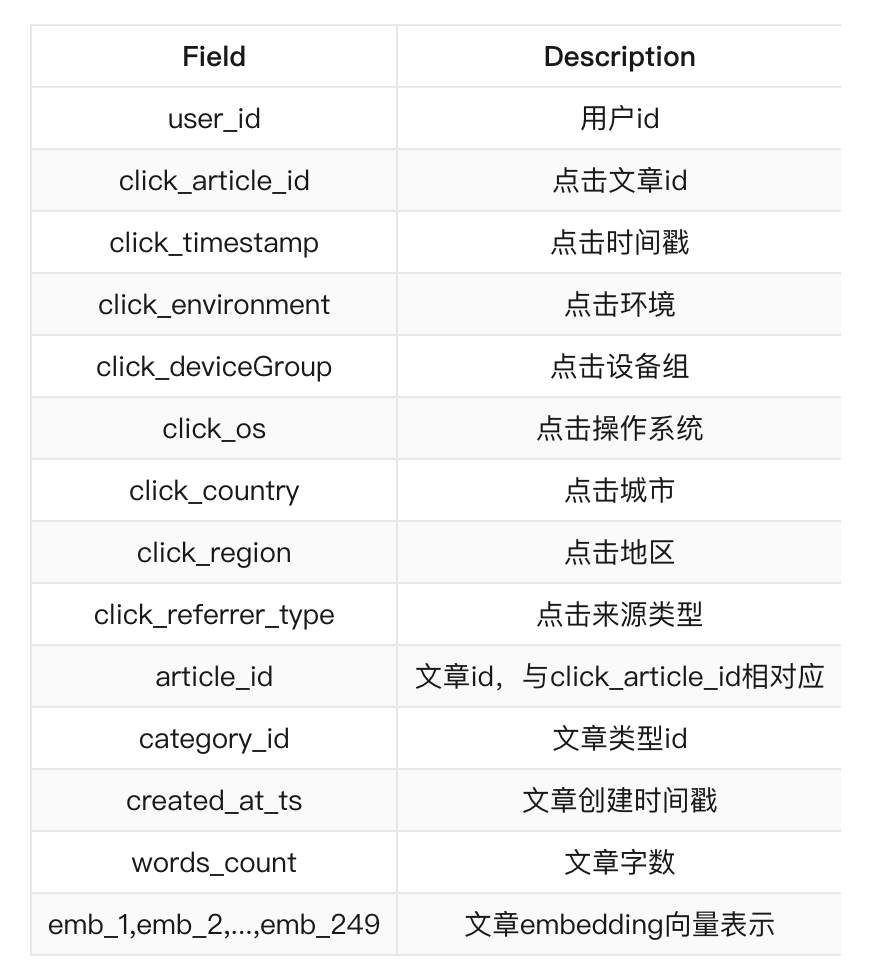

## 数据分析

### 导包

In [151]:
# 导入相关包
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='SimHei', size=13)

import os,gc,re,warnings,sys
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler

In [86]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/www-kaggle-comdatasetsalthealam/articles.csv
/kaggle/input/www-kaggle-comdatasetsalthealam/testA_click_log.csv
/kaggle/input/www-kaggle-comdatasetsalthealam/train_click_log.csv
/kaggle/input/www-kaggle-comdatasetsalthealam/articles_emb.csv
/kaggle/input/www-kaggle-comdatasetsalthealam/sample_submit.csv
/kaggle/input/news-recommendation-dataset/articles.csv
/kaggle/input/news-recommendation-dataset/testA_click_log.csv
/kaggle/input/news-recommendation-dataset/train_click_log.csv
/kaggle/input/news-recommendation-dataset/articles_emb.csv
/kaggle/input/news-recommendation-dataset/sample_submit.csv


### 读取数据

In [87]:
path='/kaggle/input/news-recommendation-dataset/'

#####train
trn_click = pd.read_csv(path+'train_click_log.csv')
item_df = pd.read_csv(path+'articles.csv')
item_df = item_df.rename(columns={'article_id': 'click_article_id'})  #重命名，方便后续match
item_emb_df = pd.read_csv(path+'articles_emb.csv')

#####test
tst_click = pd.read_csv(path+'testA_click_log.csv')

### 数据预处理

In [88]:
# 对每个用户的点击时间戳进行排序
trn_click['rank'] = trn_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)
tst_click['rank'] = tst_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)

In [89]:
#计算用户点击文章的次数，并添加新的一列count
trn_click['click_cnts'] = trn_click.groupby(['user_id'])['click_timestamp'].transform('count')
tst_click['click_cnts'] = tst_click.groupby(['user_id'])['click_timestamp'].transform('count')

### 数据浏览

#### 用户点击日志文件_训练集

In [90]:
trn_click = trn_click.merge(item_df, how='left', on=['click_article_id'])
trn_click.head()

# user_id: 用户的唯一标识
# click_article_id: 用户点击的文章唯一标识
# click_timestamp: 用户点击文章时的时间戳
# click_environment: 用户点击文章的环境
# click_deviceGroup: 用户点击文章的设备组
# click_os: 用户点击文章时的操作系统
# click_country: 用户点击文章时的所在的国家
# click_region: 用户点击文章时所在的区域
# click_referrer_type: 用户点击文章时，文章的来源

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11,281,1506942089000,173
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11,4,1506994257000,118
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11,99,1507013614000,213
3,199998,157770,1507029532200,4,1,17,1,25,5,40,40,281,1506983935000,201
4,199998,96613,1507029671831,4,1,17,1,25,5,39,40,209,1506938444000,185


In [91]:
# 用户点击日志信息
trn_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112623 entries, 0 to 1112622
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   user_id              1112623 non-null  int64
 1   click_article_id     1112623 non-null  int64
 2   click_timestamp      1112623 non-null  int64
 3   click_environment    1112623 non-null  int64
 4   click_deviceGroup    1112623 non-null  int64
 5   click_os             1112623 non-null  int64
 6   click_country        1112623 non-null  int64
 7   click_region         1112623 non-null  int64
 8   click_referrer_type  1112623 non-null  int64
 9   rank                 1112623 non-null  int64
 10  click_cnts           1112623 non-null  int64
 11  category_id          1112623 non-null  int64
 12  created_at_ts        1112623 non-null  int64
 13  words_count          1112623 non-null  int64
dtypes: int64(14)
memory usage: 118.8 MB


In [92]:
trn_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06
mean,1.221198e+05,1.951541e+05,1.507588e+12,3.947786e+00,1.815981e+00,1.301976e+01,1.310776e+00,1.813587e+01,1.910063e+00,7.118518e+00,1.323704e+01,3.056176e+02,1.506598e+12,2.011981e+02
std,5.540349e+04,9.292286e+04,3.363466e+08,3.276715e-01,1.035170e+00,6.967844e+00,1.618264e+00,7.105832e+00,1.220012e+00,1.016095e+01,1.631503e+01,1.155791e+02,8.343066e+09,5.223881e+01
min,0.000000e+00,3.000000e+00,1.507030e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.166573e+12,0.000000e+00
25%,7.934700e+04,1.239090e+05,1.507297e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,2.000000e+00,4.000000e+00,2.500000e+02,1.507220e+12,1.700000e+02
50%,1.309670e+05,2.038900e+05,1.507596e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00,4.000000e+00,8.000000e+00,3.280000e+02,1.507553e+12,1.970000e+02
75%,1.704010e+05,2.777120e+05,1.507841e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00,8.000000e+00,1.600000e+01,4.100000e+02,1.507756e+12,2.280000e+02
max,1.999990e+05,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00,2.410000e+02,2.410000e+02,4.600000e+02,1.510666e+12,6.690000e+03


In [93]:
# 训练集中的用户数量为200000
trn_click.user_id.nunique()

200000

In [94]:
# 查看训练集中每个用户至少点击的文章数量
# 即每个用户至少点击两篇文章
trn_click.groupby('user_id')['click_article_id'].count().min()

2

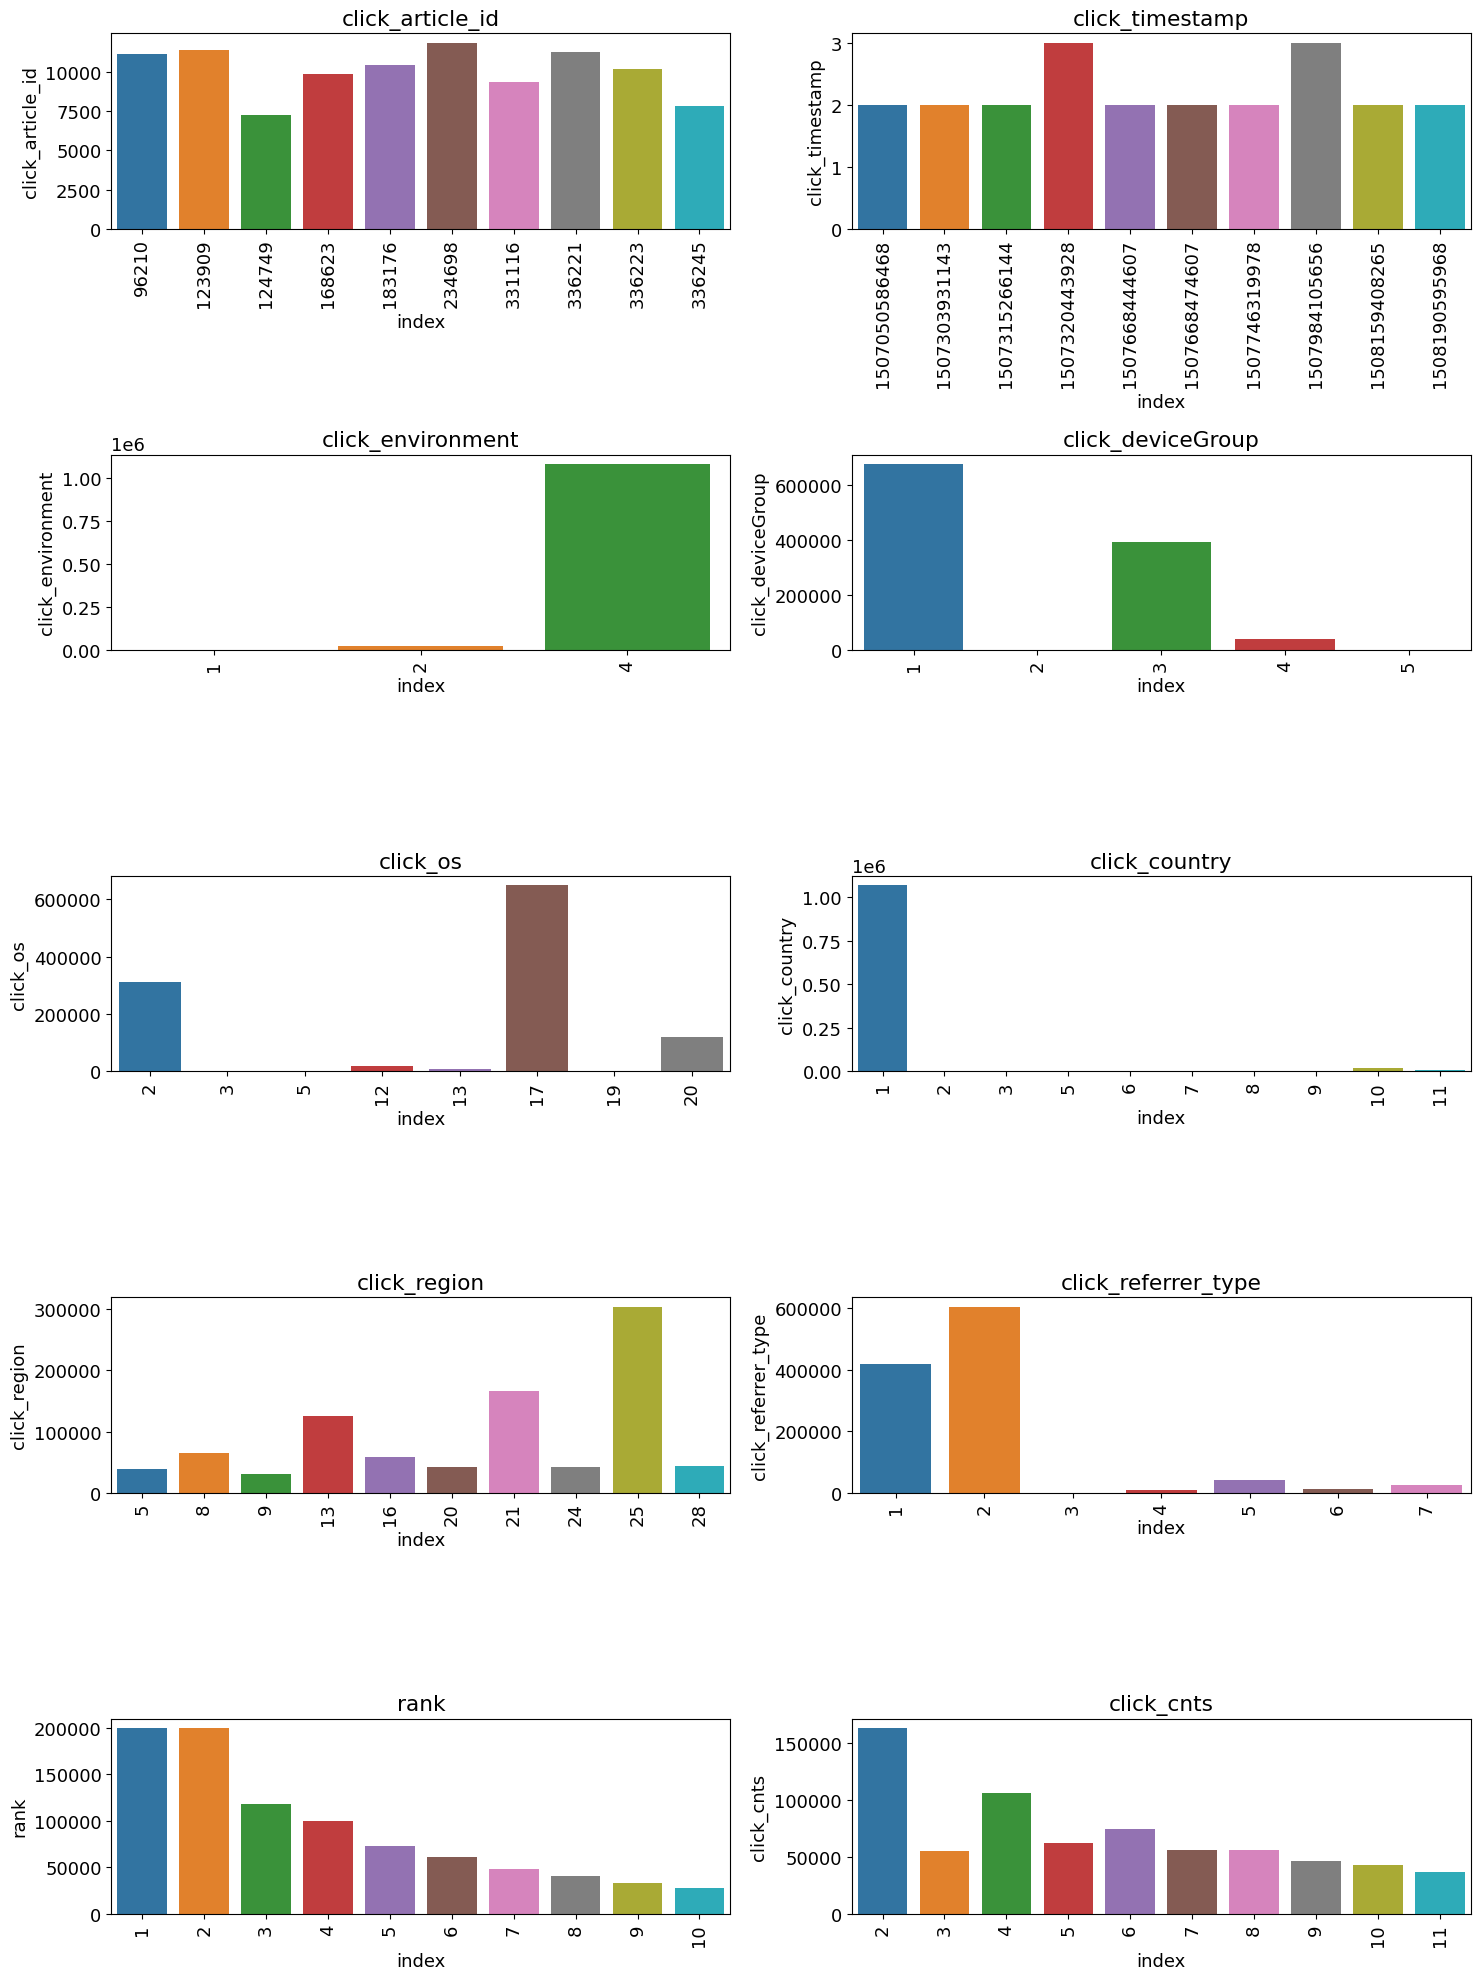

In [95]:
# 可视化trn_click数据集中不同列的前10个最频繁出现的值
plt.figure(figsize=(15, 20)) # 创建一个新的图形，宽为15，长为20
i = 1 # 用于跟踪当前创建的子图的位置

# 遍历一个包含列名的列表
for col in ['click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 
            'click_region', 'click_referrer_type', 'rank', 'click_cnts']:
    # 创建一个子图，参数5，2标识图形被分为5行2列，i是当前子图的编号
    plot_envs = plt.subplot(5, 2, i)
    i += 1 # 每次循环后，计数器i增加1
    # 对当前列col中的值进行计数，然后重置索引，使其成为一个datafrane，并且取10行
    v = trn_click[col].value_counts().head(10).reset_index()
    v.columns=['index',col] # 明确的命名列
    # 创建条形图
    fig = sns.barplot(x=v['index'], y=v[col])
    # 遍历条形图的x轴刻度标签，并将它们旋转90度
    for item in fig.get_xticklabels():
        item.set_rotation(90)
    plt.title(col) # 设置标题，标题是当前正在处理的列名
plt.tight_layout() # 自动调整子图参数，使之填充整个图形区域
plt.show()

#### 测试集用户点击日志

In [96]:
tst_click=tst_click.merge(item_df,how='left',on=['click_article_id'])
tst_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,249999,160974,1506959142820,4,1,17,1,13,2,19,19,281,1506912747000,259
1,249999,160417,1506959172820,4,1,17,1,13,2,18,19,281,1506942089000,173
2,249998,160974,1506959056066,4,1,12,1,13,2,5,5,281,1506912747000,259
3,249998,202557,1506959086066,4,1,12,1,13,2,4,5,327,1506938401000,219
4,249997,183665,1506959088613,4,1,17,1,15,5,7,7,301,1500895686000,256


In [97]:
tst_click.describe()
# 训练集的用户id由0-199999，测试集A的用户id为200000-249999

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,518010.000000,518010.000000,5.180100e+05,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,5.180100e+05,518010.000000
mean,227342.428169,193803.792550,1.507387e+12,3.947300,1.738285,13.628467,1.348209,18.250250,1.819614,15.521785,30.043586,305.324961,1.506883e+12,210.966331
std,14613.907188,88279.388177,3.706127e+08,0.323916,1.020858,6.625564,1.703524,7.060798,1.082657,33.957702,56.868021,110.411513,5.816668e+09,83.040065
min,200000.000000,137.000000,1.506959e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.265812e+12,0.000000
25%,214926.000000,128551.000000,1.507026e+12,4.000000,1.000000,12.000000,1.000000,13.000000,1.000000,4.000000,10.000000,252.000000,1.506970e+12,176.000000
50%,229109.000000,199197.000000,1.507308e+12,4.000000,1.000000,17.000000,1.000000,21.000000,2.000000,8.000000,19.000000,323.000000,1.507249e+12,199.000000
75%,240182.000000,272143.000000,1.507666e+12,4.000000,3.000000,17.000000,1.000000,25.000000,2.000000,18.000000,35.000000,399.000000,1.507630e+12,232.000000
max,249999.000000,364043.000000,1.508832e+12,4.000000,5.000000,20.000000,11.000000,28.000000,7.000000,938.000000,938.000000,460.000000,1.509949e+12,3082.000000


In [98]:
# 测试集的用户数量为50000
tst_click.user_id.nunique()

50000

In [99]:
# 测试集中每个user最少点击1个文章
tst_click.groupby('user_id')['click_article_id'].count().min()

1

#### 新闻文章信息数据表

In [100]:
# 新闻文章信息数据集浏览
item_df.head()

,click_article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162


In [101]:
item_df['words_count'].value_counts()

words_count
176     3485
182     3480
179     3463
178     3458
174     3456
        ... 
556        1
625        1
2798       1
767        1
841        1
Name: count, Length: 866, dtype: int64

In [102]:
# 总共有461个文章主题
item_df['category_id'].nunique()

461

<Axes: >

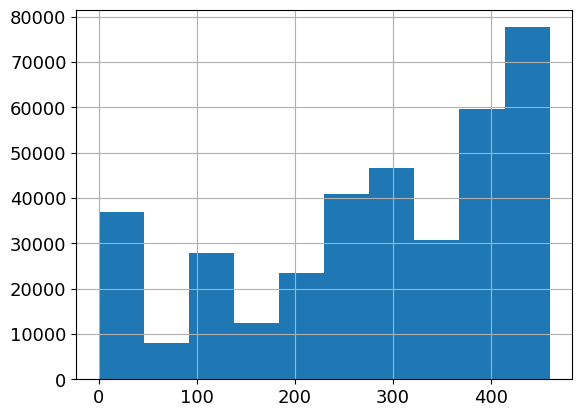

In [103]:
item_df['category_id'].hist()

In [104]:
# 总共有254047篇文章
item_df.shape

(364047, 4)

#### 新闻文章embedding向量表示

In [105]:
item_emb_df.head()

,article_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249
0,0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,...,-0.487843,0.823124,0.412688,-0.338654,0.320786,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


In [106]:
item_emb_df.shape

(255756, 251)

### 数据分析

#### 1. 用户角度

#### 用户重复点击

In [107]:
### merge
user_click_merge=pd.concat([trn_click,tst_click],ignore_index=True)

In [110]:
user_click_merge.shape

(1630633, 14)

In [111]:
# 用户重复点击
# 计算每一个user_id重复阅读某个click_article_id的次数count
user_click_count=user_click_merge.groupby(['user_id','click_article_id'])['click_timestamp'].agg({'count'}).reset_index()
user_click_count[:10]

,user_id,click_article_id,count
0,0,30760,1
1,0,157507,1
2,1,63746,1
3,1,289197,1
4,2,36162,1
5,2,168401,1
6,3,36162,1
7,3,50644,1
8,4,39894,1
9,4,42567,1


In [112]:
# 找到每个user_id点击一个click_article_id的次数大于7的数据
user_click_count[user_click_count['count']>7]

,user_id,click_article_id,count
311242,86295,74254,10
311243,86295,76268,10
393761,103237,205948,10
393763,103237,235689,10
576902,134850,69463,13


In [113]:
user_click_count['count'].nunique()

9

In [114]:
# 用户点击新闻次数的出现次数（比如点击次数为1的出现了1605541次）
user_click_count.loc[:,'count'].value_counts()
# .loc[:,'count']中，loc是pandas中用于访问数据的索引器，允许我们通过标签名来选择数据:表示选择所有的行，count表示选择的列
# value_counts()：统计序列中每个唯一值出现的次数

# 也就是说有1605541（大约99.2%）的用户没有重复阅读过文章，仅有极少数用户重复点击过某篇文章

count
1     1605541
2       11621
3         422
4          77
5          26
6          12
10          4
7           3
13          1
Name: count, dtype: int64

#### 用户点击环境变化

In [124]:
def plot_envs(df, cols, r, c):
    # df：需要绘制的数据
    # cols：列表，包含了要从df中绘制计数的列名
    # r：子图的行数
    # c：子图的列数
    plt.figure(figsize=(10, 5))
    i = 1 # 用于跟踪当前正在创建的子图的位置
    for col in cols: # 遍历cols列表中的每个列名
        plt.subplot(r, c, i) # 创建一个子图，位置由r（行数）、c（列数）和i（当前位置）决定
        i += 1 # 更新计数器
        v = df[col].value_counts().head(10).reset_index() # 对df中列col的值进行计数，取前10个最频繁的值，并将结果重置索引，创建一个新的dataframe
        v.columns = ['index', col]  # 明确地命名列
        fig = sns.barplot(x='index', y=col, data=v)  # 使用正确的列名
        for item in fig.get_xticklabels(): # 遍历条形图的x轴刻度标签，并将它们旋转90度
            item.set_rotation(90)
        plt.title(col) # 设置子图的我标题
    plt.tight_layout()
    plt.show()

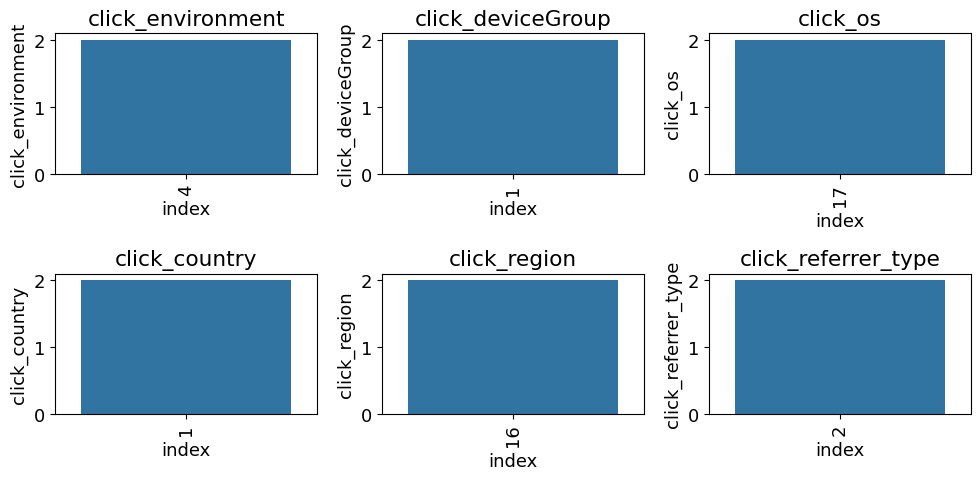

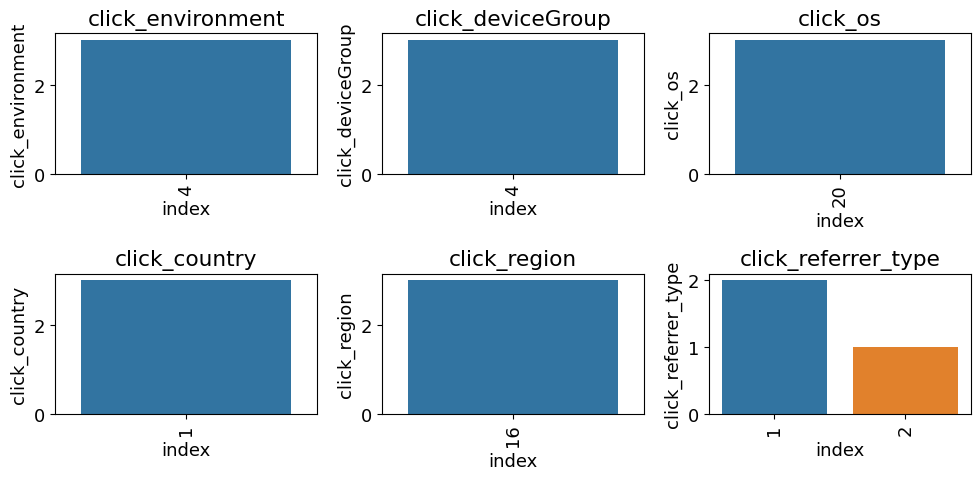

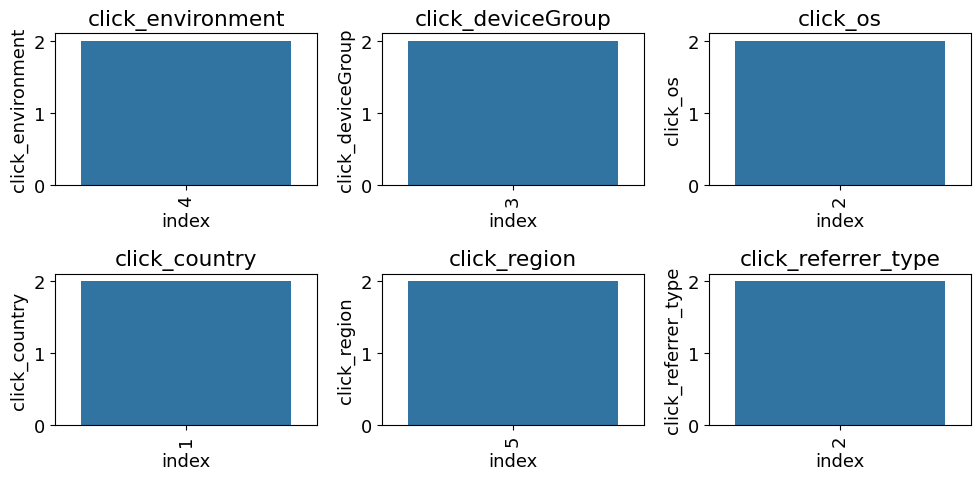

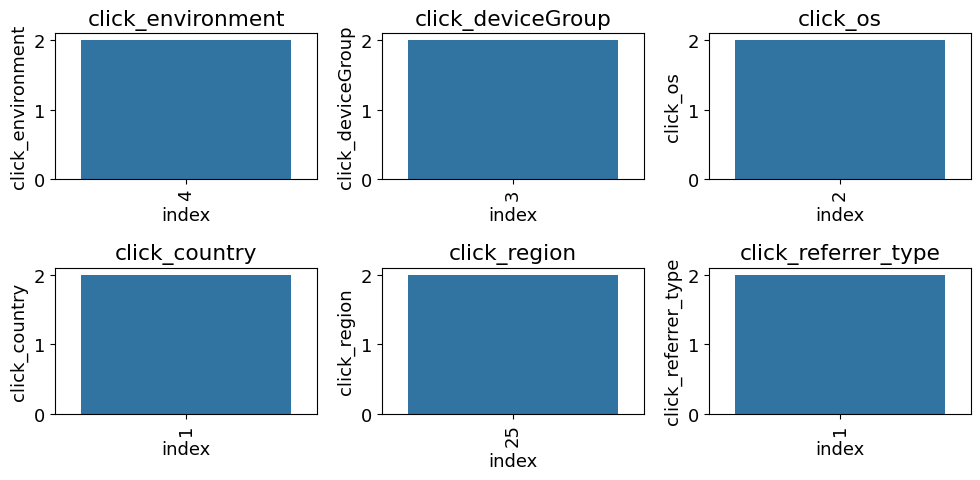

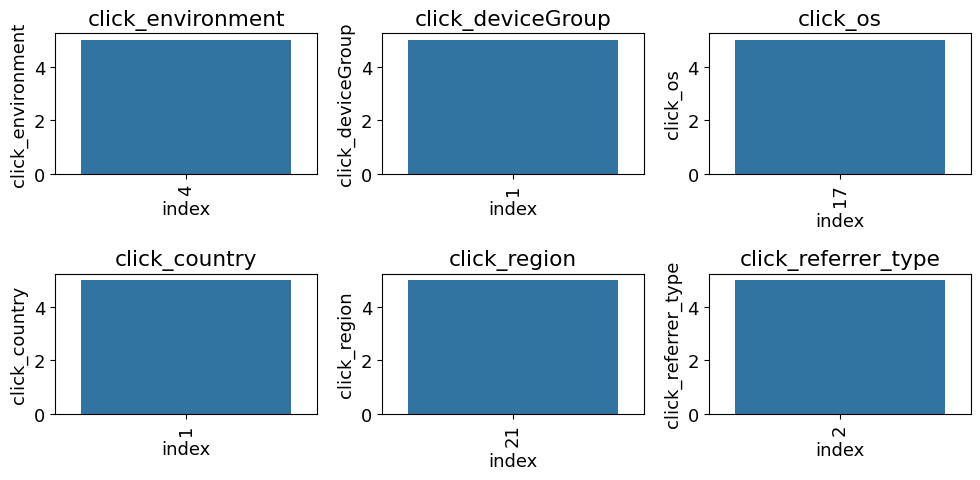

In [126]:
# 分析用户点击环境变化是否明显
# 随机采样10个用户分析这些用户的点击环境分布

# 从tst_click中的唯一user_id列表中随机选择5个不重复的值
# nunique方法返回user_id列中唯一值的数量
sample_user_ids=np.random.choice(tst_click['user_id'].nunique(),size=5,replace=False)
sample_users=user_click_merge[user_click_merge['user_id'].isin(sample_user_ids)]
cols=['click_environment','click_deviceGroup','click_os','click_country','click_region','click_referrer_type']
for _, user_df in sample_users.groupby('user_id'):
    plot_envs(user_df, cols, 2, 3)
    
# 可以发现绝大多数的用户的点击环境是比较固定的
# 思路：可以基于这些环境的统计特征来代表该用户本身的属性

#### 用户点击新闻数量的分布

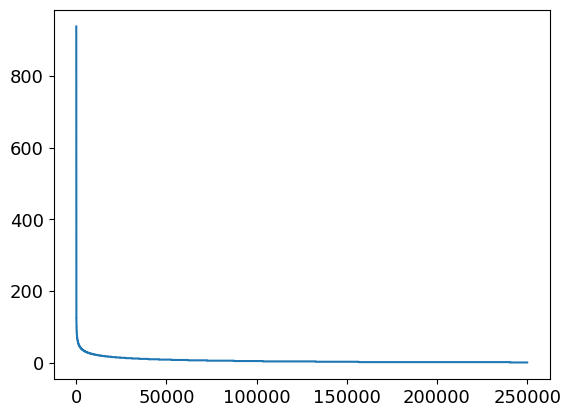

In [127]:
# 分析用户对文章的点击行为

# 计算每个用户点击的不同文章的数量并且对点击数量进行排序
user_click_item_count=sorted(user_click_merge.groupby('user_id')['click_article_id'].count(),reverse=True)
# 横轴是用户索引，纵轴是每个用户的点击文章数量
plt.plot(user_click_item_count)

#### 根据用户的点击文章次数看出用户的活跃度

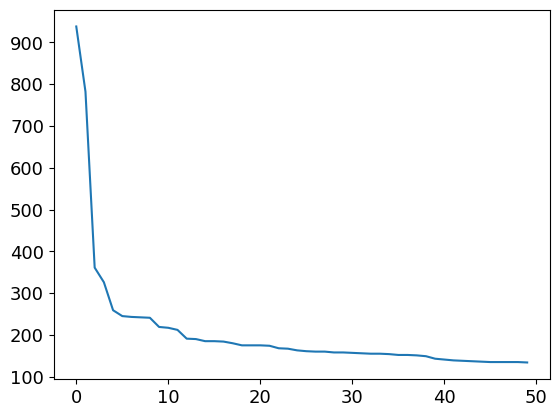

In [128]:
# 点击次数在前50的用户
plt.plot(user_click_item_count[:50])

# 点击次数排前50的用户的点击次数都在100次以上
# 思路：可以定义点击次数大于等于100次的用户为活跃用户（这是一种简单的处理次数，判断用户活跃度更全面的方法是结合上点击时间）

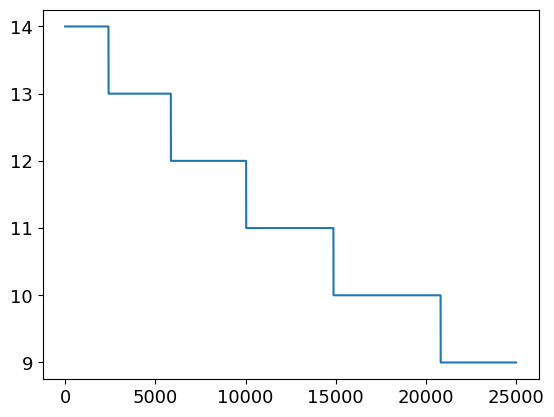

In [129]:
# 点击次数排名在[25000:50000]之间
plt.plot(user_click_item_count[25000:50000])

# 可以发现点击次数小于等于两次的用户特别多，这些用户可以认为是非活跃用户

#### 2. 新闻角度

#### 新闻点击次数分析

In [131]:
# 计算每个文章有多少不同的user_id去点击
item_click_count=sorted(user_click_merge.groupby('click_article_id')['user_id'].count(),reverse=True)

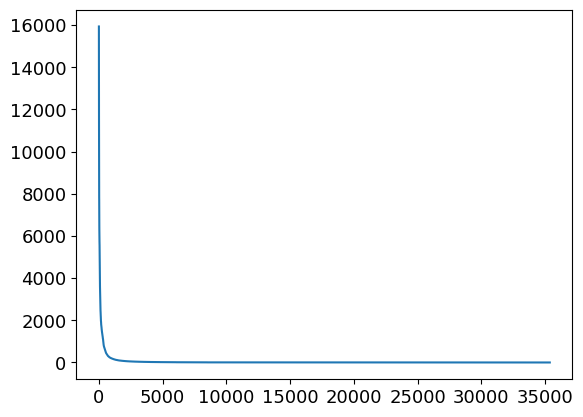

In [132]:
plt.plot(item_click_count)

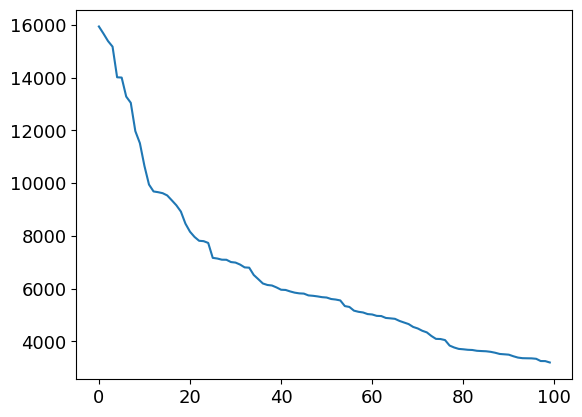

In [133]:
plt.plot(item_click_count[:100])
# 可以发现，点击次数最多的前面100个新闻，点击次数大于1000次

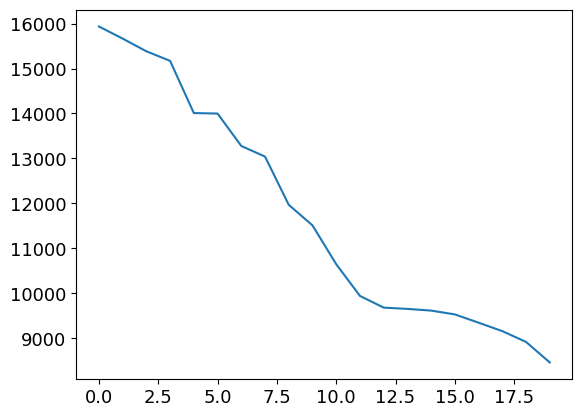

In [134]:
plt.plot(item_click_count[:20])
# 点击次数最多的前面20篇新闻，点击次数大于2500
# 思路：可以定义这些新闻为热门新闻（与活跃用户的思路相似，可以使用点击时间）

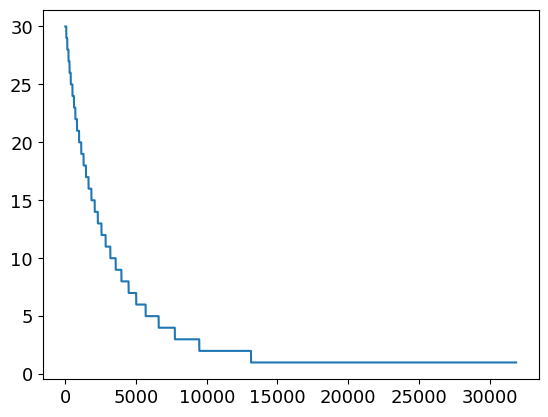

In [135]:
plt.plot(item_click_count[3500:])
# 可以发现有很多新闻只被点击过一两次
# 思路：可以定义这些新闻是冷门新闻

#### 新闻共现频次：两篇新闻连续出现的次数

In [136]:
# 按照click_timestamp进行排序
tmp=user_click_merge.sort_values('click_timestamp')
# 对每个user_id，创建一个新列next_item，它包含每个用户下一次点击的文章ID
# lambda x: x.shift(-1)是一个匿名函数，将每个用户的文章ID序列乡下移动一个位置，使得每个点击记录指向下一个点击的文章ID
# 对于每个用户的最后一次点击，next_item是NaN
tmp['next_item']=tmp.groupby(['user_id'])['click_article_id'].transform(lambda x: x.shift(-1))
union_item=tmp.groupby(['click_article_id','next_item'])['click_timestamp'].agg({'count'}).reset_index().sort_values('count',ascending=False)
union_item[['count']].describe()

# 可以看出，平均共现次数为2.88，最高为1687
# 说明用户看的新闻，相关性是比较强的

,count
count,433597.000000
mean,3.184139
std,18.851753
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2202.000000


In [138]:
union_item.head()

,click_article_id,next_item,count
283524,234698,336221.0,2202
404590,336221,95716.0,1762
95454,96210,336245.0,1751
124970,123909,168623.0,1711
12728,20691,96210.0,1568


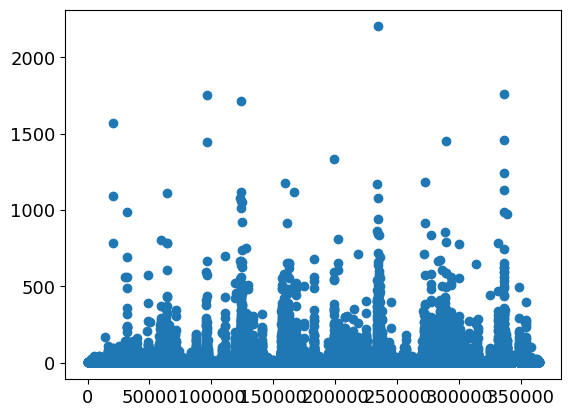

In [139]:
x=union_item['click_article_id']
y=union_item['count']
plt.scatter(x,y)

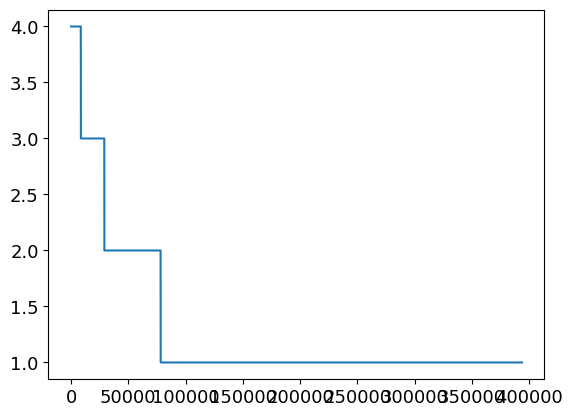

In [140]:
plt.plot(union_item['count'].values[40000:])
# 大概有70000个pair至少共现过一次

#### 新闻文章信息

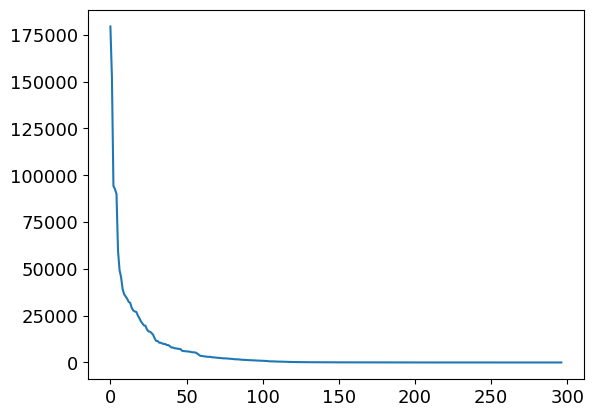

In [142]:
# 不同类型的新闻出现的次数
plt.plot(user_click_merge['category_id'].value_counts().values)

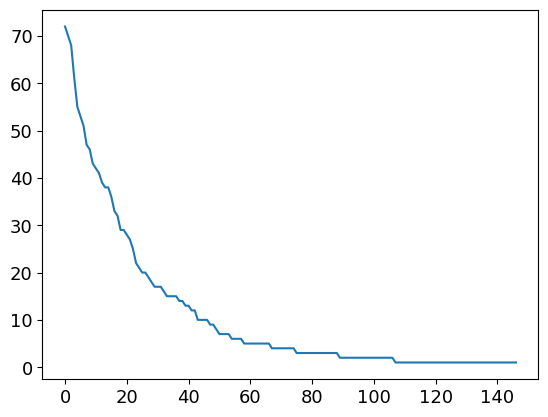

In [143]:
# 出现次数比较少的新闻类型，有些新闻类型基本上只出现过几次
plt.plot(user_click_merge['category_id'].value_counts().values[150:])

In [144]:
# 新闻次数的描述性统计
user_click_merge['words_count'].describe()

count    1.630633e+06
mean     2.043012e+02
std      6.382198e+01
min      0.000000e+00
25%      1.720000e+02
50%      1.970000e+02
75%      2.290000e+02
max      6.690000e+03
Name: words_count, dtype: float64

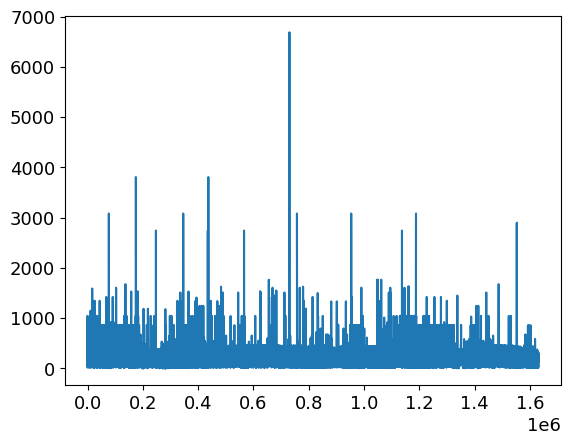

In [145]:
plt.plot(user_click_merge['words_count'].values)

#### 用户点击的新闻类型的偏好

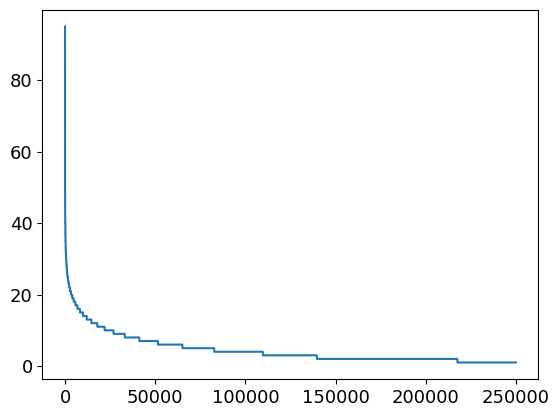

In [146]:
plt.plot(sorted(user_click_merge.groupby('user_id')['category_id'].nunique(),reverse=True))

# 可以看出一小部分用户阅读类型是极其广泛的，大部分人处在20个新闻类型以下

In [148]:
user_click_merge.groupby('user_id')['category_id'].nunique().reset_index().describe()

,user_id,category_id
count,250000.000000,250000.000000
mean,124999.500000,4.573188
std,72168.927986,4.419800
min,0.000000,1.000000
25%,62499.750000,2.000000
50%,124999.500000,3.000000
75%,187499.250000,6.000000
max,249999.000000,95.000000


#### 用户查看文章的长度的分布

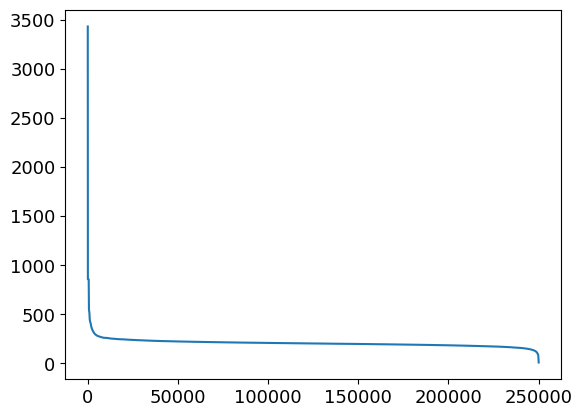

In [149]:
# 通过统计不同用户点击新闻的平均字数，可以反应用户是对长文还是短文更感兴趣
plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(),reverse=True))

# 可以看出有一小部分人看的文章平均词数非常高，也有一小部分人看的平均文章次数非常低
# 大多数人偏好于阅读字数在200-400之间的新闻

In [150]:
user_click_merge.groupby('user_id')['words_count'].mean().reset_index().describe()

# 可以发现大多数人都是看250字以下的文章

,user_id,words_count
count,250000.000000,250000.000000
mean,124999.500000,205.830189
std,72168.927986,47.174030
min,0.000000,8.000000
25%,62499.750000,187.500000
50%,124999.500000,202.000000
75%,187499.250000,217.750000
max,249999.000000,3434.500000


#### 用户点击新闻的时间分析

In [152]:
# 对时间进行归一化操作
mm=MinMaxScaler()
user_click_merge['click_timestamp']=mm.fit_transform(user_click_merge[['click_timestamp']])
user_click_merge['created_at_ts']=mm.fit_transform(user_click_merge[['created_at_ts']])

user_click_merge=user_click_merge.sort_values('click_timestamp')

In [153]:
user_click_merge.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
1112641,249990,162300,0.000000,4,3,20,1,25,2,5,5,281,0.989186,193
1112625,249998,160974,0.000002,4,1,12,1,13,2,5,5,281,0.989092,259
1112653,249985,160974,0.000003,4,1,17,1,8,2,8,8,281,0.989092,259
1112673,249979,162300,0.000004,4,1,17,1,25,2,2,2,281,0.989186,193
1112648,249988,160974,0.000004,4,1,17,1,21,2,17,17,281,0.989092,259


In [160]:
def mean_diff_time_func(df,col):
    # df=pd.DataFrame(df,columns={col})
    df['time_shift1']=df[col].shift(1).fillna(0)
    df['diff_time']=abs(df[col]-df['time_shift1'])
    return df['diff_time'].mean()

#### 用户前后点击的文章的相似性分布

In [162]:
item_idx_2_rawid_dict=dict(zip(item_emb_df['article_id'],item_emb_df.index))
# 创建字典，其键是item_emb_df中article_id列的值，值是对应的索引

In [163]:
del item_emb_df['article_id']
# 删除item_emb_df中的article_id列

In [164]:
# 使用numpy的函数将item_emb_df的值转换为一个连续的内存块
item_emb_np=np.ascontiguousarray(item_emb_df.values,dtype=np.float32)

In [165]:
# 随机选择15个用户，查看这些用户前后查看文章的相似性

sub_user_ids=np.random.choice(user_click_merge.user_id.nunique(),size=15, replace=False)
# isin方法用于检查user_click_merge中的user_id是否存在于sub_user_ids列表中
sub_user_info=user_click_merge[user_click_merge['user_id'].isin(sub_user_ids)]

sub_user_info.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
1139665,239319,225055,0.002429,4,1,17,1,24,2,11,11,354,0.989211,245
1139666,239319,162655,0.002437,4,1,17,1,24,2,10,11,281,0.989199,245
1165982,229921,38708,0.004481,4,1,17,1,5,5,8,8,56,0.938530,406
1165983,229921,199198,0.004914,4,1,17,1,5,2,7,8,323,0.989226,221
1165984,229921,31023,0.004942,4,1,17,1,5,1,6,8,26,0.989218,160


In [171]:
def get_item_sim_list(df):
    """
    计算一个用户点击文章序列中连续文章对的相似度，并返回一个包含这些相似度分数的列表
    """
    sim_list=[] # 存储每对连续文章的相似度分数
    item_list=df['click_article_id'].values # 提取click_article_id列的值，并将它们存储在item_list数组中
    for i in range(0, len(item_list) - 1):
        try:
            emb1 = item_emb_np[item_idx_2_rawid_dict[item_list[i]]]
            emb2 = item_emb_np[item_idx_2_rawid_dict[item_list[i+1]]]
            sim_list.append(np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2)))
        except KeyError as e:
            print(f"KeyError: {e} - skipping this pair")
            continue
    sim_list.append(0)
    return sim_list

KeyError: 336221 - skipping this pair
KeyError: 271261 - skipping this pair
KeyError: 271261 - skipping this pair
KeyError: 313995 - skipping this pair
KeyError: 313995 - skipping this pair
KeyError: 336245 - skipping this pair
KeyError: 272242 - skipping this pair
KeyError: 272242 - skipping this pair
KeyError: 286035 - skipping this pair
KeyError: 299152 - skipping this pair
KeyError: 299152 - skipping this pair
KeyError: 277068 - skipping this pair
KeyError: 323546 - skipping this pair
KeyError: 323546 - skipping this pair
KeyError: 286321 - skipping this pair
KeyError: 270607 - skipping this pair
KeyError: 270607 - skipping this pair
KeyError: 272143 - skipping this pair
KeyError: 272143 - skipping this pair
KeyError: 293301 - skipping this pair
KeyError: 293301 - skipping this pair
KeyError: 257291 - skipping this pair
KeyError: 331738 - skipping this pair


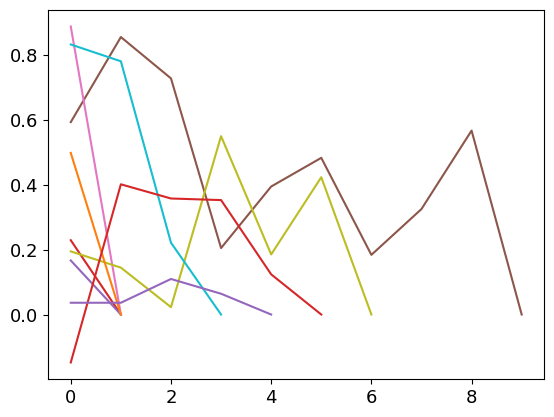

In [172]:
for _, user_df in sub_user_info.groupby('user_id'):
    item_sim_list=get_item_sim_list(user_df)
    plt.plot(item_sim_list)